# Final  Presentation: Using Word2Vec to Determine Song Sentiment Based on Lyrics

##### Objective:
The purpose of this project is to use song lyrics to determine song sentiment without taking into consideration the genre. The idea is to be able to determine the snetiment expressed by the song's lyrics so that songs that share similar characteritcis musically can be distringuished based on their lyrics.

##### Methodology:

* LDA Model for Topic Extraction
* Text Rank to understand key words in the corpus
* Taxonomy creation based on LDA and TextRank results
* Word2Vec model trained on the corpus using a skipgram approach
* Document Similarity scores using cosine similarity to determine to which topic the chorus of the song was most related to
* Accuracy score of the model comparing original lables to labels produced by the models.


In [1]:
import os
from collections import OrderedDict
import numpy as np
import nltk, re
import pandas as pd
import gensim, operator
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel,  Word2Vec, FastText
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import json
from pprint import pprint as pprint
from spacy.lang.en.stop_words import STOP_WORDS
import spacy
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

In [53]:
#Load Dataset and Create corpus
os.chdir("/Users/luislosada/Columbia Drive/Applied Text and NLP")

with open('clean_js.json') as json_file:
    df6 = json.load(json_file)

text = [df6['lyrics'][str(i)] for i in range(len(df6['lyrics']))]
chorus = [df6['chorus'][str(i)] for i in range(len(df6['chorus']))]
corp = ' '.join([t for tx in text for t in tx])
corp


"know everybody wait mean like ever since drop like know ever since drop ai nobody drop shit oh jetson make another let go hah need shit bop let go fly past whip mouth watch swervin whip cop woo bitch get good pussy fly across country finish show hop get milli legitly still shit hot nigga hot oh ask picture niggas huh name get fuck spot nigga get fuck tryna figure deal iama take uhhuh wake couple mil plate let eat invest real estate uhhuh go give mama hundred hundred probably would hear open mouth 'less hearin talkin find let go soon find flip flip bite different get dig know stiff bitch dig tryna find ai mention hah ai get dm bitch nigga dick ai free throwin ass yeah good turn around fuck make look uh like hah need shit bop let go fly past whip mouth watch swervin whip cop woo okay bitch get good pussy fly across country finish show hop yeah get milli legitly still shit hot nigga hot let go unorthodox motherfucker ayy go switch flow think would never ask niggas ai fuckin ai fuck rappi

In [26]:
#Extract Keywords
stopwords = list(set(nltk.corpus.stopwords.words('english')+['ap']+['i']+["y'all"]+['m.']+['mme']+['donot']+['rah']+['&'] + ['de']+['b']+['ca'] + ['of'] + ['us'] + ['the'] + ['at'] + ["in"] + ['and'] + ['be'] + ['it'] + ['what'] + ['sv'] +['lo'] +['d']+['n']) )
nlp = spacy.load('en_core_web_sm')

class TextRank4Keyword():

    def __init__(self):
        self.d = 0.85  # damping coefficient, usually is .85
        self.min_diff = 1e-5  # convergence threshold
        self.steps = 10  # iteration steps
        self.node_weight = None  # save keywords and its weight

    def set_stopwords(self, stopwords):
        """Set stop words"""
        for word in STOP_WORDS.union(set(stopwords)):
            lexeme = nlp.vocab[word]
            lexeme.is_stop = True

    def sentence_segment(self, doc, candidate_pos, lower):
        """Store those words only in cadidate_pos"""
        sentences = []
        for sent in doc.sents:
            selected_words = []
            for token in sent:
                # Store words only with cadidate POS tag
                if token.pos_ in candidate_pos and token.is_stop is False:
                    if lower is True:
                        selected_words.append(token.text.lower())
                    else:
                        selected_words.append(token.text)
            sentences.append(selected_words)
        return sentences

    def get_vocab(self, sentences):
        """Get all tokens"""
        vocab = OrderedDict()
        i = 0
        for sentence in sentences:
            for word in sentence:
                if word not in vocab:
                    vocab[word] = i
                    i += 1
        return vocab

    def get_token_pairs(self, window_size, sentences):
        """Build token_pairs from windows in sentences"""
        token_pairs = list()
        for sentence in sentences:
            for i, word in enumerate(sentence):
                for j in range(i + 1, i + window_size):
                    if j >= len(sentence):
                        break
                    pair = (word, sentence[j])
                    if pair not in token_pairs:
                        token_pairs.append(pair)
        return token_pairs

    def symmetrize(self, a):
        return a + a.T - np.diag(a.diagonal())

    def get_matrix(self, vocab, token_pairs):
        """Get normalized matrix"""
        # Build matrix
        vocab_size = len(vocab)
        g = np.zeros((vocab_size, vocab_size), dtype='float')
        for word1, word2 in token_pairs:
            i, j = vocab[word1], vocab[word2]
            g[i][j] = 1

        # Get Symmeric matrix
        g = self.symmetrize(g)

        # Normalize matrix by column
        norm = np.sum(g, axis=0)
        g_norm = np.divide(g, norm, where=norm != 0)  # this is ignore the 0 element in norm

        return g_norm

    def get_keywords(self, number=10):
        """Print top number keywords"""
        node_weight = OrderedDict(sorted(self.node_weight.items(), key=lambda t: t[1], reverse=True))
        for i, (key, value) in enumerate(node_weight.items()):
            print(key + ' - ' + str(value))
            if i > number:
                break

    def analyze(self, text,
                candidate_pos=['NOUN', 'PROPN'],
                window_size=4, lower=False, stopwords=list()):
        """Main function to analyze text"""

        # Set stop words
        self.set_stopwords(stopwords)

        # Pare text by spaCy
        doc = nlp(text)

        # Filter sentences
        sentences = self.sentence_segment(doc, candidate_pos, lower)  # list of list of words

        # Build vocabulary
        vocab = self.get_vocab(sentences)

        # Get token_pairs from windows
        token_pairs = self.get_token_pairs(window_size, sentences)

        # Get normalized matrix
        g = self.get_matrix(vocab, token_pairs)

        # Initionlization for weight(pagerank value)
        pr = np.array([1] * len(vocab))

        # Iteration
        previous_pr = 0
        for epoch in range(self.steps):
            pr = (1 - self.d) + self.d * np.dot(g, pr)
            if abs(previous_pr - sum(pr)) < self.min_diff:
                break
            else:
                previous_pr = sum(pr)

        # Get weight for each node
        node_weight = dict()
        for word, index in vocab.items():
            node_weight[word] = pr[index]

        self.node_weight = node_weight

# Printing Text Rank
tr4w = TextRank4Keyword()
num = [0,5,15,26,28,29,32,33,38,72,49,50,77,88,78,97,101,102,116,127,163,165,174,177,185,233,
236,247,253,266,272,274,278,299,300,328,359,410,415,434,464,491,545,554,621,628,666,685,696,733,
808,829,867,874,980]
tr4w.analyze(corp, candidate_pos=['NOUN', 'PROPN', "ADP"], window_size=8, lower=False)
tr4w.get_keywords(100)

like - 83.55163039776535
love - 52.87175791012294
time - 39.07195967081342
bitch - 29.49227688532257
bridge - 28.18655773169074
way - 26.7361573124286
girl - 25.15413637625279
life - 21.831216144676628
shit - 21.806733826334582
fuck - 21.018885051911624
mind - 18.66265719450426
prechorus - 18.364806022261995
hand - 17.217864915362224
eye - 17.057290488009052
dance - 16.059564804218
want - 15.271374748251368
thing - 14.752925871176094
play - 13.823740630713104
talk - 13.328359485966628
break - 13.31183820864842
hold - 13.285180567295969
body - 13.213088319849813
face - 12.854891533118703
dream - 12.799893834791051
things - 12.67646491910588
use - 11.455193090337875
boy - 11.401482858211041
ayy - 11.342799847378002
tryna - 11.22103451323352
turn - 11.093564207297318
word - 10.856256263938976
nigga - 10.745143036513962
star - 10.598839063842277
catch - 10.50427263701154
home - 10.3667520015522
soul - 10.285135955236022
tonight - 10.1356192908339
days - 10.051143851670314
work - 10.0222106

In [27]:
#Bigram representation for the LDA Model
bigram = gensim.models.Phrases(text, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[text], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [28]:
data_words_bigrams = make_bigrams(text)
pprint(data_words_bigrams)


[['know',
  'everybody',
  'wait',
  'mean',
  'like',
  'ever',
  'since',
  'drop',
  'like',
  'know',
  'ever',
  'since',
  'drop',
  'ai',
  'nobody',
  'drop',
  'shit',
  'oh',
  'jetson',
  'make',
  'another',
  'let',
  'go',
  'hah',
  'need',
  'shit',
  'bop',
  'let',
  'go',
  'fly',
  'past',
  'whip',
  'mouth',
  'watch',
  'swervin',
  'whip',
  'cop',
  'woo',
  'bitch',
  'get',
  'good',
  'pussy',
  'fly',
  'across',
  'country',
  'finish',
  'show',
  'hop',
  'get',
  'milli',
  'legitly',
  'still',
  'shit',
  'hot',
  'nigga',
  'hot',
  'oh',
  'ask',
  'picture',
  'niggas',
  'huh',
  'name',
  'get',
  'fuck',
  'spot',
  'nigga',
  'get',
  'fuck',
  'tryna',
  'figure',
  'deal',
  'iama',
  'take',
  'uhhuh',
  'wake',
  'couple',
  'mil',
  'plate',
  'let',
  'eat',
  'invest',
  'real',
  'estate',
  'uhhuh',
  'go',
  'give',
  'mama',
  'hundred',
  'hundred',
  'probably',
  'would',
  'hear',
  'open',
  'mouth',
  "'less",
  'hearin',
  'ta

  'watch',
  'big',
  'bank',
  'roll',
  'big',
  'ass',
  'bag',
  'big',
  "lambo'",
  'bitch',
  'g.o.a.t',
  'amiri',
  'pant',
  'tight',
  'pole',
  'bestie',
  'fuck',
  'low',
  'still',
  'trust',
  'know',
  'know',
  'outta',
  'time',
  'catch',
  'line',
  'aderall',
  'analyze',
  'lose',
  'bro',
  'lose',
  'mind',
  'want',
  'soul',
  'niggas',
  'want',
  'life',
  'tryna',
  'take',
  'hoe',
  'tryna',
  'fuck',
  'wife',
  'mood',
  'swing',
  'sometimes',
  'need',
  'two',
  'time',
  'fuckin',
  'two',
  'set',
  'twin',
  'shy',
  'fuck',
  'two',
  'set',
  '10s',
  'like',
  'couple',
  'dim',
  'fuck',
  'two',
  'set',
  'twin',
  'like',
  'couple',
  'time',
  'fuck',
  'set',
  'twin',
  'like',
  'couple',
  'time',
  'percocets',
  'two',
  'time',
  'percocets',
  'never',
  'know',
  'come',
  'percocets',
  'two',
  'time',
  'percocets',
  'never',
  'know',
  'come',
  'prechorus',
  'beast',
  'oh',
  'god',
  'mood',
  'swing',
  'line',
  'moo

  'really',
  'want'],
 ['prechorus',
  'corona',
  'rhythm_rhythm',
  'rhythm_rhythm',
  'rhythm_rhythm',
  'rhythm_rhythm',
  'rhythm_rhythm',
  'rhythm_rhythm',
  'rhythm_rhythm',
  'rhythm',
  'balvin',
  'corona',
  'will.i.am',
  'toda_noche',
  'rompemo_al',
  'otro_día',
  'volvemo',
  'oh',
  'yeah',
  'tú_sabes',
  'como_hacemo',
  'rhythm',
  'tonight',
  'like',
  'fuego',
  'spend_dinero',
  'oh',
  'yeah',
  'party',
  'extremo',
  'rhythm',
  'toda_noche',
  'rompemo_al',
  'otro_día',
  'volvemo',
  'oh',
  'yeah',
  'tú_sabes',
  'como_hacemo',
  'rhythm',
  'tonight',
  'like',
  'fuego',
  'spend_dinero',
  'oh',
  'yeah',
  'party',
  'extremo_extremo',
  'extremo_extremo',
  'extremo',
  'instrumental',
  'bridge',
  'ritmo',
  'balvin',
  'son',
  'ni',
  'reebok',
  'ni',
  'son',
  'nike',
  'sin',
  'estilista',
  'luzco',
  'fly',
  'yes',
  'rosalía',
  'dice',
  'que',
  'luzco',
  'guay',
  'rosalía',
  'te',
  'niego',
  'porque',
  'sé',
  'que',
  'hay',

  'lie',
  'lie'],
 ['saturday',
  'nights',
  'blueberry',
  'cigarillos',
  'swishers',
  'make',
  'throat',
  'hurt',
  'roll',
  'ocb',
  'side',
  'let',
  'burn',
  'feud',
  'say',
  'mom',
  'confuse',
  'shit',
  'want',
  'learn',
  'daddy',
  'go',
  'say',
  'never',
  'home',
  'wish',
  'make',
  'worse',
  'prechorus',
  'guess',
  'certain',
  'dream',
  'get',
  'keep',
  'know',
  'let',
  'see',
  'things',
  'know',
  'parent_care',
  'like',
  'nowhere',
  'like',
  'things',
  'know',
  'parent_care',
  'like',
  'nowhere',
  'like',
  'nowhere',
  'like',
  'nowhere',
  'like',
  'saturday',
  'nights',
  'silverado',
  'drive',
  'stay',
  'work',
  'late',
  'job',
  'hate',
  'fix',
  'makeup',
  'dirty',
  'bathroom',
  'love',
  'club',
  'know',
  'get',
  'get',
  'plan',
  'wrap',
  'rubber',
  'band',
  'thing',
  'never',
  'lose',
  'prechorus',
  'guess',
  'certain',
  'dream',
  'get',
  'keep',
  'know',
  'let',
  'see',
  'things',
  'know',
  '

  'believe',
  'need',
  'would',
  'stay',
  'hold',
  'wait',
  'wish',
  'good',
  'enough',
  'hold',
  'wait',
  'could',
  'wake',
  'hold',
  'wait',
  'love',
  'love',
  'love',
  'love',
  'would',
  'stay',
  'hold',
  'wait',
  'wish',
  'care',
  'hold',
  'wait',
  'wish',
  'would',
  'tell',
  'hold',
  'wait',
  'love',
  'love',
  'love',
  'love',
  'would',
  'stay',
  'hold',
  'wait',
  'stay',
  'hold',
  'wait',
  'faith',
  'shake',
  'still',
  'believe',
  'stay',
  'hold',
  'wait',
  'love',
  'love',
  'love',
  'would',
  'stay'],
 ['danny',
  'run',
  'complications',
  'fall',
  'asleep',
  'conversations',
  'get',
  'search',
  'street',
  'vacation',
  'worst',
  'thing',
  'situation',
  'sit',
  'think',
  'know',
  'would',
  'collapse',
  'vein',
  'wear',
  'beautiful',
  'shoe',
  'live',
  'danny',
  'say',
  'live',
  'simulation',
  'work',
  'petrol',
  'station',
  'sell',
  'petrol',
  'say',
  'begin',
  'operation',
  'know',
  'think',

  'sin',
  'thing',
  'take',
  'way',
  'far',
  'come',
  'clear',
  'across',
  'like',
  'compass',
  'star',
  'oh',
  'show',
  'way',
  'want',
  'make',
  'side',
  'take',
  'angel',
  'grin',
  'beam',
  'nothing',
  'might',
  'aget',
  'along',
  'oh',
  'lose',
  'without',
  'voice',
  'keep',
  'go',
  'refrain',
  'keep',
  'go',
  'keep',
  'go',
  'like',
  'keep',
  'go',
  'keep',
  'go',
  'like',
  'sweet',
  'sin',
  'thing',
  'never',
  'never',
  'another',
  'never',
  'cut',
  'time',
  'enough',
  'much',
  'like',
  'lay',
  'save',
  'soul',
  'breath',
  'nothing',
  'might',
  'aget',
  'along',
  'oh',
  'lose',
  'without',
  'voice',
  'keep',
  'go',
  'refrain',
  'keep',
  'go',
  'keep',
  'go',
  'like',
  'keep',
  'go',
  'keep',
  'go',
  'like',
  'bridge',
  'keep',
  'go',
  'wilded',
  'mind',
  'string',
  'road',
  'call',
  'get',
  'old',
  'ah',
  'crazy',
  'would',
  'let',
  'nothing',
  'hope',
  'think',
  'make',
  'whole',
  '

  'say',
  'true',
  'get',
  'slow',
  'play',
  'rule',
  'joker',
  'fool',
  'guess',
  'catch',
  'want',
  'affection',
  'lie',
  'tear',
  'get',
  'attention',
  'would',
  'lie',
  'tear',
  'try',
  'tell',
  'intention',
  'lie',
  'tear',
  'want',
  'affection',
  'would',
  'mind',
  'tear',
  'prechorus',
  'know',
  'want',
  'careless',
  'company',
  'oh',
  'say',
  'true',
  'get',
  'slow',
  'play',
  'rule',
  'joker',
  'fool',
  'guess',
  'catch',
  'want',
  'affection',
  'lie',
  'tear',
  'get',
  'attention',
  'would',
  'lie',
  'tear',
  'try',
  'tell',
  'intention',
  'lie',
  'tear',
  'want',
  'affection',
  'would',
  'mind',
  'tear'],
 ['yeah',
  'get',
  'better',
  'get',
  'cheddar',
  'feel',
  'like',
  'king',
  'coretta',
  'make',
  'livin',
  'never',
  'go',
  'give',
  'way',
  'drive',
  "thinkin'",
  'scar',
  'sinkin',
  'scar',
  'fallin',
  'think',
  'ballin',
  'maybe',
  'give',
  'damn',
  'back',
  "beginnin'",
  'plan',


  'say',
  'like',
  'rid',
  'sunset',
  'boulevard',
  'try',
  'find',
  'rid',
  'sunset',
  'boulevard',
  'try',
  'find',
  'l.a',
  'would',
  'tell',
  'get',
  'would',
  'tell',
  'get',
  'yeah'],
 ['pharrell',
  'ladies',
  'gentlemen',
  'introduce',
  'friend',
  'mine',
  'yes',
  'yes',
  'go',
  'name',
  'wooo',
  'way',
  'memphis',
  'tennessee',
  'get',
  'somethin',
  'special',
  'tonight',
  'go',
  'sing',
  'song',
  'girl',
  'come',
  'right',
  'yeah',
  'come',
  'pharrell',
  'sunny',
  'know',
  'would',
  'meet',
  'beautiful',
  'girl',
  'walk',
  'street',
  'see',
  'bright',
  'eye',
  'tear',
  'come',
  'say',
  'deserve',
  'crown',
  'mama',
  'listen',
  'señorita',
  'feel',
  'deal',
  'things',
  'love',
  'tell',
  'charm',
  'could',
  'feel',
  'real',
  'love',
  'lay',
  'run',
  'fast',
  'mind',
  'girl',
  'slow',
  'carry',
  'way',
  'thing',
  'might',
  'leave',
  'grind',
  'would',
  'like',
  'fly',
  'ride',
  'still',
  '

  'dream',
  'prechorus',
  'oh',
  'ohooh',
  'come',
  'unstuck',
  'run_riptide',
  'take',
  'away',
  'dark',
  'side',
  'want',
  'leave',
  'hand',
  'love',
  'sing',
  'song',
  'get',
  'lump_throat',
  'go',
  'sing',
  'word',
  'wrong',
  'movie',
  'think',
  'like',
  'guy',
  'decide',
  'quit',
  'job',
  'head',
  'york',
  'cowboy',
  'run',
  'live',
  'highest',
  'shelf',
  'prechorus',
  'oh',
  'ohooh',
  'come',
  'unstuck',
  'run_riptide',
  'take',
  'away',
  'dark',
  'side',
  'want',
  'leave',
  'hand',
  'love',
  'sing',
  'song',
  'get',
  'lump_throat',
  'go',
  'sing',
  'word',
  'wrong',
  'bridge',
  'want',
  'want',
  'know',
  'go',
  'go',
  'stay',
  'get',
  'get',
  'know',
  'way',
  'swear',
  'destine',
  'screen',
  'closest',
  'thing',
  'michelle',
  'pfeiffer',
  'ever',
  'see',
  'oh',
  'run_riptide',
  'take',
  'away',
  'dark',
  'side',
  'want',
  'leave',
  'hand',
  'love',
  'sing',
  'song',
  'get',
  'lump_throat'

  'word',
  'bleed',
  'inside',
  'page',
  'hold',
  'ever',
  'let',
  'go',
  'away',
  'remember',
  'kiss',
  'lamppost',
  'back',
  'sixth',
  'street',
  'hear',
  'whisper',
  'phone',
  'wait',
  'come',
  'home'],
 ['silly',
  'moment',
  'storm',
  'calm',
  'deep',
  'die',
  'breath',
  'love',
  'work',
  'seem',
  'hold',
  'like',
  'want',
  'feel',
  'arm',
  'nobody',
  'go',
  'come',
  'save',
  'pull',
  'many',
  'false',
  'alarm',
  'go',
  'see',
  'go',
  'know',
  'doom',
  'dear',
  'slow',
  'dance',
  'burn',
  'room',
  'always',
  'dream',
  'try',
  'draw',
  'dare',
  'say',
  'nothing',
  'ever',
  'saw',
  'make',
  'sadness',
  'bitch',
  'try',
  'hit',
  'hurt',
  'leave',
  'feel',
  'dirty',
  'understand',
  'go',
  'see',
  'go',
  'know',
  'doom',
  'dear',
  'slow',
  'dance',
  'burn',
  'room',
  'bridge',
  'go',
  'cry',
  'go',
  'cry',
  'go',
  'cry',
  'dear',
  'slow',
  'dance',
  'burn',
  'room',
  'burn',
  'room',
  'burn',

  'go',
  'season',
  'change',
  'love',
  'go',
  'cold',
  'fee',
  'flame',
  'let',
  'go',
  'away',
  'run_circle',
  'away',
  'away',
  'dare',
  'something',
  'wait',
  'take',
  'blame',
  'away',
  'run_circle',
  'away',
  'away',
  'away'],
 ['yeah',
  'ayy',
  'want',
  'close',
  'time',
  'leave',
  'yeah',
  'get',
  'love',
  'spend',
  'oh',
  'let',
  'find',
  'place',
  'happiness',
  'begin',
  'prechorus',
  'go',
  'dance',
  'live',
  'room',
  'slave',
  'way',
  'move',
  'hurt',
  'leave',
  'ayy',
  'dance',
  'live',
  'room',
  'love',
  'attitude',
  'drink',
  "'80s",
  'ayy',
  'go',
  'dance',
  'live',
  'room',
  'slave',
  'way',
  'move',
  'hurt',
  'leave',
  'ayy',
  'dance',
  'live',
  'room',
  'love',
  'attitude',
  'drink',
  'human',
  'know',
  'real',
  'would',
  'fight',
  'try',
  'deny',
  'way',
  'feel',
  'oh',
  'babe',
  'fool',
  'body',
  'get',
  'plan',
  'stop',
  'pretend',
  'shy',
  'come',
  'dance',
  'dance',
  '

  'voy',
  'eh',
  'porque',
  'tu',
  'lado',
  'di',
  'cuenta',
  'que',
  'nada',
  'soy',
  'ehey',
  'cansé',
  'luchar',
  'guerrear',
  'en',
  'vano',
  'estar',
  'en',
  'línea',
  'fuego',
  'meter',
  'mano',
  'acepto',
  'mis',
  'errore',
  'también',
  'soy',
  'humano',
  'tú',
  'que',
  'hago',
  'porque',
  'te',
  'amo',
  'pupupupum',
  'prechorus',
  'farruko',
  'pero',
  'tengo',
  'más',
  'que',
  'hacer',
  'aquí',
  'aquí',
  'voy',
  'llegó',
  'hora',
  'e',
  'partir',
  'partir',
  'mi',
  'propio',
  'camino',
  'seguir',
  'lejos',
  'ti',
  'sabrina_carpenter',
  'take',
  'aim',
  'away',
  'never',
  'wide',
  'awake',
  'nobody',
  'keep',
  'safe',
  'way',
  'rise',
  'rise',
  'nana',
  'burn',
  'eye',
  'burn',
  'eye',
  'nobody',
  'keep',
  'safe',
  'way',
  'instrumental',
  'break',
  'farruko',
  'blep',
  'way',
  'bridge',
  'sabrina_carpenter',
  'everybody',
  'everybody',
  'keep',
  'safe',
  'everybody',
  'everybody',
  'keep'

  'best',
  'see',
  'take',
  'atake_chancechance',
  'take',
  'take',
  'take',
  'atake_chancechance',
  'take',
  'take',
  'get',
  'put',
  'test',
  'take',
  'take',
  'atake_chancechance',
  'take',
  'take',
  'take',
  'atake_chancechance',
  'take',
  'take',
  'take',
  'take',
  'take'],
 ['oh',
  'eye',
  'eye',
  'make',
  'star',
  'look',
  'like',
  "shinin'",
  'hair',
  'hair',
  'fall',
  'perfectly',
  'without',
  'try',
  'beautiful',
  'tell',
  'every',
  'yeah',
  'know',
  'know',
  'compliment',
  'would',
  'believe',
  'sad',
  'think',
  'see',
  'see',
  'every',
  'time',
  'ask',
  'look',
  'okay',
  'say',
  'see',
  'face',
  'thing',
  'would',
  'change',
  'amaze',
  'way',
  'smile',
  'whole',
  'stop',
  'star',
  'girl',
  'amaze',
  'way',
  'lips',
  'lips',
  'could',
  'kiss',
  'would',
  'let',
  'laugh',
  'laugh',
  'hat',
  'think',
  'sexy',
  'beautiful',
  'tell',
  'every',
  'oh',
  'know',
  'know',
  'know',
  'would',
  'n

  'dog',
  'cry',
  'grow',
  'restless',
  'long',
  'solitary',
  'company',
  'know',
  'must',
  'right',
  'sure',
  'kilimanjaro',
  'rise',
  'like',
  'olympus',
  'serengeti',
  'seek',
  'cure',
  'deep',
  'inside',
  'frighten',
  'thing',
  'become',
  'kimball',
  'go',
  'take',
  'lot',
  'drag',
  'away',
  'nothing',
  'hundred',
  'could',
  'ever',
  'bless',
  'rain',
  'africa',
  'go',
  'take',
  'time',
  'things',
  'never',
  'bridge',
  'hurry',
  'boy',
  'wait',
  'kimball',
  'go',
  'take',
  'lot',
  'drag',
  'away',
  'nothing',
  'hundred',
  'could',
  'ever',
  'bless',
  'rain',
  'africa',
  'bless',
  'rain',
  'africa',
  'bless',
  'rain',
  'africa',
  'bless',
  'rain',
  'africa',
  'bless',
  'rain',
  'africa',
  'go',
  'take',
  'time',
  'things',
  'never'],
 ['yeah',
  'yeah',
  'yeah',
  'yeah',
  'yeah',
  'yeah',
  'yeah',
  'yeah',
  'yeah',
  'yeah',
  'yeah',
  'yeah',
  'yeah',
  'yeah',
  'think',
  'make',
  'believe',
  'oh

  'miles',
  'would',
  'five_hundred',
  'walk',
  'thousand_miles',
  'fall',
  'door',
  'postchorus',
  'tadadata_tadadata',
  'tadadata_tadadata',
  'tadadadanteladanteladanteleladada',
  'tadadata_tadadata',
  'tadadata_tadadata',
  'tadadadanteladanteladanteleladada',
  'tadadata_tadadata',
  'tadadata_tadadata',
  'tadadadanteladanteladanteleladada',
  'tadadata_tadadata',
  'tadadata_tadadata',
  'tadadadanteladanteladanteleladada',
  'would',
  'five_hundred',
  'miles',
  'would',
  'five_hundred',
  'walk',
  'thousand_miles',
  'fall',
  'door'],
 ['lookin',
  'eye',
  'see',
  'paradise',
  'find',
  'good',
  'true',
  'standin',
  'beside',
  'want',
  'much',
  'give',
  'love',
  'feelin',
  'let',
  'say',
  'crazy',
  'care',
  'put',
  'hand',
  'hand',
  'ever',
  'look',
  'back',
  'prechorus',
  'let',
  'around',
  'fall_apart',
  'make',
  'build',
  'dream',
  'together',
  'stand',
  'strong',
  'forever',
  'nothing',
  'go',
  'stop',
  'run',
  'lovers',

  'stay_younger',
  'together',
  'let',
  'stay_younger',
  'together',
  'let',
  'stay_younger',
  'together',
  'let',
  'stay_younger',
  'together',
  'let',
  'stay_younger',
  'together',
  'let',
  'stay_younger',
  'together',
  'let',
  'stay_younger',
  'together',
  'let',
  'stay_younger',
  'together'],
 ['oh',
  'sweet',
  'psycho',
  'bite',
  'psycho_screamin',
  'iammamama',
  'mind',
  'oh',
  'hot',
  'psycho',
  'leave',
  'right',
  'though',
  'screamin_iammamama',
  'mind',
  'make',
  'curse',
  'bless',
  'rip',
  'shirt',
  'within',
  'second',
  'come',
  'back',
  'back',
  'plate',
  'help',
  'prechorus',
  'play',
  'alooong',
  'let',
  'lead',
  'ooon',
  'say',
  'say',
  'yes',
  'yes',
  'yes',
  'messin',
  'oh',
  'sweet',
  'psycho',
  'bite',
  'psycho_screamin',
  'iammamama',
  'mind',
  'oh',
  'hot',
  'psycho',
  'leave',
  'right',
  'though',
  'screamin_iammamama',
  'mind',
  'postchorus',
  'grab',
  'cop',
  'gun',
  'kinda',
  'cra

  'say',
  'tough',
  'love',
  'uptown',
  'girl',
  'live',
  'bread',
  'long',
  'anyone',
  'hot',
  'look',
  'downtown'],
 ['hey',
  'go',
  'days',
  'rain',
  'come',
  'hollow',
  'playin',
  'laugh',
  'run',
  'hey',
  'hey',
  'skip',
  'jump',
  'misty',
  'morning',
  'fog',
  'hearts',
  'thumpin',
  'browneyed',
  'girl',
  'browneyed',
  'girl',
  'whatever',
  'happen',
  'tuesday',
  'slow',
  'go',
  'old',
  'mine',
  'transistor',
  'radio',
  'stand',
  'sunlight',
  'laugh',
  'hide',
  'behind',
  'rainbow',
  'slip_slide',
  'along',
  'waterfall',
  'browneyed',
  'girl',
  'browneyed',
  'girl',
  'remember',
  'use',
  'sing',
  'sha',
  'te',
  'like',
  'sha',
  'te',
  'te',
  'hard',
  'find',
  'way',
  'saw',
  'grow',
  'cast',
  'memory',
  'back',
  'sometimes',
  'overcome',
  'think',
  'make',
  'love',
  'grass',
  'behind',
  'stadium',
  'browneyed',
  'girl',
  'browneyed',
  'girl',
  'remember',
  'use',
  'sing',
  'sha',
  'te',
  'sha'

  'jermaine',
  'oh',
  'show',
  'love',
  'want',
  'back',
  'jackie',
  'forget',
  'happen',
  'want',
  'back',
  'jermaine',
  'let',
  'live',
  'oh',
  'blind',
  'let',
  'go',
  'since',
  'see',
  'arm',
  'want',
  'back',
  'jackie',
  'spare',
  'jermaine',
  'gim',
  'back',
  'lose',
  'oh',
  'need',
  'ha',
  'tell',
  'love',
  'oh',
  'oh',
  'oh',
  'want',
  'back'],
 ['music',
  'within',
  'language',
  'understand',
  'equal',
  'opportunity',
  'sing',
  'dance',
  'clap',
  'hand',
  'make',
  'tell',
  'right',
  'away',
  'letter',
  'people',
  'start',
  'move',
  'feel',
  'feel',
  'people',
  'feel',
  'feel',
  'people',
  'music',
  'know',
  'always',
  'things',
  'life',
  'would',
  'quit',
  'music',
  'pioneer',
  'time',
  'allow',
  'forget',
  'basie',
  'satchmo',
  'king',
  'sir',
  'duke',
  'voice',
  'like',
  'ring',
  'way',
  'lose',
  'feel',
  'feel',
  'people',
  'feel',
  'feel',
  'people',
  'feel',
  'feel',
  'people',
  '

  'geeze',
  'something',
  'see',
  'oh',
  'home',
  'let',
  'come',
  'home',
  'home',
  'whenever',
  'oh',
  'home',
  'let',
  'come',
  'home',
  'home',
  'wherever',
  'postchorus',
  'bridge',
  'take',
  'home',
  'daddy',
  'come',
  'home',
  'bridge',
  'alexander',
  'speak',
  'alexander',
  'remember',
  'fell',
  'outta',
  'window',
  'sure',
  '‒',
  'come',
  'jump',
  'well',
  'fell',
  'concrete',
  'nearly',
  'break',
  'ass',
  'bleed',
  'place',
  'rush',
  'hospital',
  'remember',
  'yes',
  'well',
  'something',
  'never',
  'tell',
  'tell',
  'sit',
  'back',
  'seat',
  'smoke',
  'cigarette',
  'think',
  'go',
  'last',
  'fall',
  'deep',
  'deeply',
  'love',
  'never',
  'tell',
  'aww',
  'oh',
  'home',
  'let',
  'come',
  'home',
  'home',
  'whenever',
  'oh',
  'home',
  'let',
  'come',
  'home',
  'home',
  'alone',
  'alexander',
  'home',
  'let',
  'come',
  'home',
  'home',
  'wherever',
  'home',
  'yes',
  'home',
  'home',
  'a

  'things',
  'know',
  'frustrate',
  'still',
  'like',
  'dance',
  'eye',
  'damn',
  'eye',
  'get',
  'every',
  'time',
  'eye',
  'eye',
  'crime',
  'dance',
  'like',
  'care',
  'call',
  'fred_astaire',
  'eye',
  'damn',
  'eye',
  'get',
  'every',
  'time',
  'eye',
  'eye',
  'crime',
  'dance',
  'like',
  'care',
  'call',
  'fred_astaire',
  'bridge',
  'lose',
  'else',
  'ever',
  'see',
  'quite',
  'like',
  'eye',
  'damn',
  'eye',
  'get',
  'every',
  'time',
  'eye',
  'eye',
  'crime',
  'dance',
  'like',
  'care',
  'call',
  'fred_astaire',
  'eye',
  'damn',
  'eye',
  'get',
  'every',
  'time',
  'eye',
  'eye',
  'crime',
  'dance',
  'like',
  'care',
  'call',
  'fred_astaire',
  'ooh',
  'ooh',
  'ooh',
  'ooh',
  'ooh',
  'ooh',
  'ooh',
  'ooh',
  'call',
  'fred_astaire',
  'eye',
  'damn',
  'eye',
  'get',
  'every',
  'time',
  'ooh',
  'ooh',
  'ooh',
  'ooh',
  'ooh',
  'ooh',
  'ooh',
  'ooh'],
 ['people',
  'say',
  'nothing',
  'really'

  'figure',
  'tonight',
  'figure',
  'push',
  'lack',
  'chest',
  'look',
  'hair',
  'get',
  'love',
  'way',
  'love',
  "'your",
  'obsession',
  'rock',
  'fuck',
  'whole',
  'reflection',
  'mental',
  "health'",
  'prechorus',
  'remember',
  'find',
  'much',
  'younger',
  'start',
  'round',
  'create',
  'television',
  'mouth',
  'tonight',
  'figure',
  'tonight',
  'figure',
  'bridge',
  'get',
  'something',
  'say',
  'speak',
  'instead',
  'live',
  'always',
  'take',
  'instead',
  'live',
  'tonight',
  'figure',
  'tonight',
  'figure'],
 ['know',
  'need',
  'key',
  'would',
  'forget',
  'lose',
  'paris',
  'lose',
  'paris',
  'lose',
  'paris',
  'hope',
  'warm',
  'safe',
  'memory',
  'replace',
  'lose',
  'paris',
  'lose',
  'paris',
  'things',
  'use',
  'say',
  'keep',
  'place',
  'would',
  'go',
  'songs',
  'get',
  'know',
  'hold',
  'know',
  'need',
  'key',
  'would',
  'forget',
  'lose',
  'paris',
  'lose',
  'paris',
  'hope',
  

  'ai',
  'nobody',
  'play',
  'want',
  'change',
  'ai',
  'nobody',
  'change',
  'say',
  'take',
  'slow',
  'think',
  'want',
  'change',
  'watch',
  'tryna',
  'play',
  'ai',
  'nobody',
  'play',
  'want',
  'change',
  'ai',
  'nobody',
  'change',
  'say',
  'take',
  'slow',
  'think'],
 ['find',
  'daydream',
  'better',
  'memories',
  'bleed',
  'open',
  'london',
  'cloud',
  'cry',
  'dance',
  'pour',
  'rain',
  'grow',
  'life',
  'learn',
  'fall_apart',
  'prechorus',
  'closer',
  'high',
  'vibrations',
  'earn',
  'sweeter',
  'deeper',
  'wave',
  'make',
  'peace',
  'true',
  'every',
  'way',
  'know',
  'alright',
  'know',
  'survive',
  'know',
  'rise',
  'believe',
  'love',
  'even',
  'hard',
  'livin',
  'scar',
  'never',
  'mount',
  'nothing',
  'believe',
  'love',
  'nobody',
  'tell',
  'grow',
  'get',
  'know',
  'emotional',
  'define',
  'past',
  'balance',
  'key',
  'understand',
  'always',
  'sometimes',
  'right',
  'road',
  'go

  'want',
  'give',
  'time',
  'want',
  'make',
  'good',
  'blow',
  'mind',
  'promise',
  'boy',
  'true',
  'perfect',
  'find',
  'tell',
  'want',
  'think',
  'would',
  'sleep',
  'boy',
  'wrong',
  'dream',
  'first',
  'kiss',
  'first',
  'make',
  'feel',
  'like',
  'opportunity',
  'miss',
  'boy',
  'want',
  'know',
  'deal',
  'wonder',
  'word',
  'say',
  'real',
  'get',
  'appeal',
  'whole',
  'get',
  'know',
  'feel',
  'yeah',
  'tell',
  'want',
  'give',
  'time',
  'want',
  'make',
  'good',
  'blow',
  'mind',
  'promise',
  'boy',
  'true',
  'perfect',
  'find',
  'tell',
  'want',
  'sweetheart',
  'time',
  'let',
  'know',
  'want',
  'rush',
  'take',
  'slow',
  'boy',
  'love',
  'help',
  'grow',
  'give',
  'begin',
  'give',
  'happy',
  'end',
  'fade',
  'tell',
  'want',
  'want',
  'make',
  'good',
  'promise',
  'girl',
  'true',
  'tell',
  'want',
  'tell',
  'want',
  'want',
  'make',
  'good',
  'promise',
  'girl',
  'true',
  'te

  'aaa_aaa',
  'aa_aaa',
  'aa_aaa',
  'aaa_aaa',
  'aaa_aaa',
  'aa_aaa',
  'aa_aaa',
  'ai',
  'sleep',
  'wicked',
  'play',
  'yodel',
  'ay',
  'ayy',
  'hoo_hoo',
  'ai',
  'love',
  'wicked',
  'yodel',
  'ah',
  'ay_ay',
  'wicked',
  'ones',
  'wicked',
  'ones'],
 ['walk',
  'street',
  'corner',
  'eye',
  'saw',
  'pretty',
  'thing',
  'approach',
  'say',
  'never',
  'see',
  'look',
  'alone',
  'oh',
  'could',
  'use',
  'company',
  'pay',
  'right',
  'price',
  'even',
  'nice',
  'go',
  'send',
  'way',
  'say',
  'sweet',
  'thing',
  'look',
  'say',
  'oh',
  'ai',
  'rest',
  'wicked',
  'grow',
  'tree',
  'get',
  'bill',
  'pay',
  'get',
  'mouth',
  'fee',
  'ai',
  'nothing',
  'free',
  'oh',
  'slow',
  'hold',
  'back',
  'though',
  'know',
  'wish',
  'could',
  'oh',
  'ai',
  'rest',
  'wicked',
  'close',
  'eye',
  'good',
  'even',
  'minutes',
  'later',
  'still',
  'walk',
  'street',
  'saw',
  'shadow',
  'creep',
  'sight',
  'sweep',
  

  'love',
  'say',
  'friend',
  'know',
  'want',
  'come',
  'cold',
  'tire',
  'lyng',
  'need',
  'need',
  'need',
  'need'],
 ['waste',
  'wait',
  'space',
  'waste',
  'wait',
  'waste',
  'wait',
  'place',
  'waste',
  'wait',
  'oh',
  'wait',
  'mind',
  'oh',
  'face',
  'find',
  'oh',
  'way',
  'waste',
  'wait',
  'time',
  'waste',
  'feel',
  'many',
  'ways',
  'turn',
  'around',
  'many',
  'ways',
  'make',
  'hide',
  'things',
  'find',
  'something',
  'bridge',
  'go',
  'change',
  'go',
  'change',
  'babe',
  'go',
  'change',
  'babe',
  'go',
  'change',
  'hold',
  'season',
  'especially',
  'fall',
  'give',
  'mm',
  'need',
  'reason',
  'make',
  'sense',
  'give',
  'oh',
  'love',
  'cave',
  'space',
  'oh',
  'love',
  'cave',
  'space',
  'oh',
  'love',
  'cave',
  'space',
  'oh',
  'love',
  'cave'],
 ['hard',
  'play',
  'victim',
  'ooh',
  'scar',
  'belong',
  'walk',
  'contradiction',
  'practice',
  'preach',
  'would',
  'heavy',
 

  'never',
  'see',
  'anything',
  'lovely',
  'slow',
  'want',
  'get',
  'know',
  'turn',
  'around',
  'pretty',
  'round',
  'thing',
  'look',
  'good',
  'slow',
  'never',
  'see',
  'anything',
  'lovely',
  'turn',
  'around',
  'bless',
  'beauty'],
 ['p.diddy',
  'send',
  'ladies',
  'sexy',
  'mamas',
  'come',
  'come',
  'come',
  'proceed',
  'give',
  'need',
  'know',
  'like',
  'body',
  'go',
  'bump',
  'bump',
  'bump',
  'boy',
  'talk',
  'playa',
  'p.diddy',
  'like',
  'sexy',
  'style',
  'love',
  'get',
  'wild',
  'girl',
  'girl',
  'need',
  'magazines',
  'wear_crown',
  'ghetto',
  'like',
  'bling',
  'bling',
  'bling',
  'way',
  'shake',
  'sexy',
  'ass',
  'body',
  'shape',
  'like',
  'hour',
  'glass',
  'need',
  'spend',
  'time',
  'want',
  'get',
  'nobody',
  'else',
  'things',
  'something',
  'need',
  'turn',
  'around',
  'let',
  'see',
  'sexy',
  'body',
  'go',
  'bump',
  'bump',
  'bump',
  'want',
  'see',
  'show',
  's

  'nut',
  'wake',
  'shout',
  'fuck',
  'goin',
  'smokey',
  'swayze',
  'time',
  'get',
  'brewin',
  'figure',
  'way',
  'rush',
  'runway',
  'lookin',
  'wild',
  'derange',
  'common',
  'without',
  'qualm',
  'inside',
  'tookin',
  'lookin',
  'fiends',
  'pebble',
  'adore',
  'praise',
  'devil',
  'raise',
  'crystallize',
  'tombs',
  'fume',
  'floor',
  'blaze',
  'sole',
  'sacrificial',
  'altar',
  'choose',
  'halt',
  'worship',
  'dealin',
  'ultimate',
  'headrush',
  'lead',
  'crush',
  'buyer',
  'seller',
  'decoratin',
  'hell',
  'flame',
  'choir',
  'firearms',
  'blame',
  'mornin',
  'time',
  'clear',
  'everybody',
  'see',
  'massacre',
  'local',
  'folk',
  'cheer',
  'oh',
  'thank',
  'almighty',
  'pharmacy',
  'business',
  'lose',
  'chubby',
  'widow',
  'cry',
  'alone',
  'get',
  '2x'],
 ['two',
  'two',
  'two',
  'two',
  'two',
  'two',
  'find',
  'meet',
  'skyline',
  'knock',
  'back',
  'whiskey',
  'like',
  'say',
  'finish',


  'gas',
  'early',
  'drive',
  'get',
  'bullet',
  'koozie',
  'keep',
  'ice',
  'cold',
  'take',
  'sip',
  "'fore",
  'get',
  'go',
  'lookin',
  'hand',
  'window',
  'turnin',
  'right',
  'turnin',
  'yeah',
  'ridin_roads',
  'nobody',
  'go',
  'trip',
  'country',
  'side',
  '38s',
  'makin',
  'go',
  "'round",
  'hit',
  'curb',
  'make',
  'slide',
  'flash',
  'yellow',
  'thing',
  'want',
  'kiss',
  'lovin',
  'nothin',
  'ridin_roads',
  'like',
  'postchorus',
  'ridin_roads',
  'hit',
  'water',
  'lips',
  'hit',
  'mine',
  'know',
  'somebody',
  'steal',
  'street',
  'sign',
  'iama',
  'take',
  'sweet',
  'time',
  'yeah',
  'could',
  'go',
  'forever',
  'ridin',
  'shotgun',
  'yeah',
  'probably',
  'makin',
  'plan',
  'yeah',
  'already',
  'get',
  'ridin_roads',
  'nobody',
  'go',
  'trip',
  'country',
  'side',
  '38s',
  'makin',
  'go',
  "'round",
  'hit',
  'curb',
  'make',
  'slide',
  'flash',
  'yellow',
  'thing',
  'want',
  'kiss',


  'thot',
  'cock',
  'nigga',
  'mulatto',
  'ai',
  'fuckin',
  'thot_box',
  'make',
  'eat',
  'droptop',
  'skrrt',
  'think',
  'ill',
  'hot',
  'rack',
  'comin',
  'nonstop',
  'yeah',
  'big',
  'rock',
  'croptop',
  'rock',
  'croptop',
  'take',
  'benz',
  'chopshop',
  'ooh',
  'ai',
  'fuckin',
  'thot_box',
  'gettin',
  'top',
  'droptop',
  'mmh'],
 ['ayy',
  'rvssian',
  'mamacita',
  'tryna',
  'reach',
  'pull',
  'see',
  'yeah',
  'meet',
  'ayy',
  'holdin',
  'want',
  'mamacita',
  'yeah',
  'tryna',
  'reach',
  'pull',
  'pull',
  'see',
  'yeah',
  'meet',
  'yeah',
  'holdin',
  'want',
  'ayy',
  'mamacita',
  'could',
  'bang',
  'could',
  'blow',
  'speakers',
  'yeah',
  'could',
  'piece',
  'nice',
  'ah',
  'go',
  'señorita',
  'go',
  'go',
  'miss',
  'anitta',
  'ayy',
  'get',
  'pink',
  'ice',
  'like',
  'easter',
  'ice',
  'tell',
  'boyfriend',
  'hasta',
  'vista',
  'bye',
  'take',
  'pic',
  'mona',
  'lisa',
  'like',
  'big',
  'b

  'scrape',
  'every',
  'dollar',
  'hope',
  'know',
  'would',
  'erase',
  'pain',
  'ogs',
  'thankin',
  'watchin',
  'pavin',
  'grind',
  'copy',
  'cadence',
  'mirror',
  'style',
  'study',
  'greats',
  'greatest',
  'right',
  'fuck',
  'feel',
  'ai',
  'get',
  'choice',
  'ai',
  'promo',
  'still',
  'make',
  'noise',
  'year',
  'go',
  'different',
  'set',
  'intentions',
  'promise',
  'slap',
  'hate',
  'voice',
  'refrain',
  'niggas',
  'countin',
  'countin',
  'bullets',
  'loadin',
  'clip',
  'writin',
  'name',
  'makin',
  'list',
  'checkin',
  'twice',
  'gettin',
  'hit',
  'real',
  'ones',
  'dyin',
  'fake',
  'ones',
  'light',
  'balance',
  'back',
  'shit',
  'bentley',
  'dirty',
  'sneakers',
  'dirty',
  'like',
  'dick',
  'pour',
  'somethin',
  'cup',
  'wantin',
  'somethin',
  'feel',
  'promise',
  'never',
  'lettin',
  'palm',
  'make',
  'real',
  'foot',
  'neck',
  'get',
  'stick',
  'iama',
  'give',
  'somethin',
  'feel',
  'a

  'watch',
  'spend',
  'get',
  'light',
  'like',
  'las',
  'vegas',
  'yeah',
  'big',
  'sittin',
  'acres',
  'acres',
  'never',
  'see',
  'neighbor',
  'durag',
  'wavy',
  'goddamn',
  'start',
  'bottom',
  'get',
  'bag',
  'ai',
  'look',
  'back',
  'since',
  'start',
  'say',
  'sorry',
  'fuck',
  'shit',
  'start',
  'hatin',
  'love',
  'drip',
  'start',
  'bottom',
  'get',
  'bag',
  'ai',
  'look',
  'back',
  'since',
  'start',
  'say',
  'sorry',
  'fuck',
  'shit',
  'start',
  'hatin',
  'love',
  'drip',
  'bridge',
  'know',
  'fine',
  'okay',
  'yeah',
  'dime',
  'okay',
  'cut',
  'ever',
  'get',
  'outta',
  'line',
  'okay',
  'big',
  'okay',
  'like',
  'okay',
  'waste',
  'ever',
  'waste',
  'time',
  'okay',
  'get',
  'outta',
  'line',
  'okay',
  'goin',
  'okay',
  'know',
  'temper',
  'way',
  'shorter',
  'okay',
  'mama',
  'wait',
  'line',
  'okay',
  'say',
  'well',
  'like',
  'mufasa',
  'lyin',
  'okay',
  'well',
  'okay',
  's

  'good',
  'ai',
  'mine',
  'call',
  'look',
  'photos',
  'get',
  'hot',
  'lose',
  'want',
  'let',
  'go',
  'prechorus',
  'need',
  'lie',
  'truth',
  'without',
  'boy',
  'stronger',
  'know',
  'say',
  'change',
  'cold',
  'leave',
  'scar',
  'ooh',
  'call',
  'go',
  'tonight',
  'feel',
  'good',
  'outta',
  'life',
  'want',
  'talk',
  'get',
  'leave',
  'behind',
  'drink',
  'outta',
  'mind',
  'take',
  'high',
  'alone',
  'go',
  'mind',
  'want',
  'talk',
  'call',
  'look',
  'fine',
  'babe',
  'get',
  'eye',
  'look',
  'way',
  'everybody',
  'vibe',
  'babe',
  'call',
  'say',
  'listen',
  'back',
  'tryna',
  'hit',
  'prechorus',
  'need',
  'lie',
  'truth',
  'without',
  'boy',
  'stronger',
  'know',
  'say',
  'change',
  'cold',
  'leave',
  'scar',
  'ooh',
  'call',
  'go',
  'tonight',
  'feel',
  'good',
  'outta',
  'life',
  'want',
  'talk',
  'get',
  'leave',
  'behind',
  'drink',
  'outta',
  'mind',
  'take',
  'high',
  'alon

  'thing',
  'set',
  'pace',
  'go',
  'tell',
  'stop',
  'couple',
  'bruddahs',
  'get',
  'job',
  'couple',
  'buy',
  'sell',
  'grow',
  'slide',
  'round',
  'north',
  'manny',
  'kinda',
  'tell',
  'see',
  'girl',
  'chick',
  'look',
  'fly',
  'well',
  'louis',
  'crepe',
  'belt',
  'bag',
  'chanel',
  'rest',
  'step',
  'level',
  'get',
  'best',
  'ai',
  'stress',
  'much',
  'ai',
  'fake',
  'shit',
  'ai',
  'go',
  'beg',
  'love',
  'gally',
  'love',
  'anyway',
  'big',
  'shelly',
  'wet',
  'show',
  'flex',
  'make',
  'shake',
  'back',
  'pretty',
  'face',
  'gal_tryna',
  'get',
  'taste',
  'bop',
  'give',
  'fuck',
  'place',
  'gucci_buckle',
  'snake',
  'look',
  'bape',
  'show',
  'flex',
  'make',
  'shake',
  'back',
  'pretty',
  'face',
  'gal_tryna',
  'get',
  'taste',
  'bop',
  'give',
  'fuck',
  'place',
  'gucci_buckle',
  'snake',
  'look',
  'bape',
  'aim',
  'get',
  'bag',
  'get',
  'ai',
  'get',
  'time',
  'rest',
  'sett

  'wife',
  'ai',
  'safe',
  'ai',
  'safe',
  'ai',
  'safe',
  'ai',
  'safe',
  'ai',
  'safe',
  'tell',
  'pipe',
  'nigga',
  'pipe',
  'hunnit',
  'band',
  'safe',
  'face',
  'would',
  'say',
  'ayy',
  'ayy',
  'ayy',
  'ayy',
  'ayy',
  'dance',
  'turn',
  'shit',
  'nightclub',
  'ayy',
  'ayy',
  'ayy',
  'ayy',
  'postchorus',
  'geazy',
  'yeah',
  'fuck',
  'get',
  'yeah',
  'ayy',
  'fuck',
  'get',
  'ayy',
  'yeah',
  'fuck',
  'get',
  'ayy',
  'yeah',
  'fuck',
  'get',
  'need',
  'tongue',
  'need',
  'face',
  'give',
  'brain',
  'concentrate',
  'apple',
  'phone',
  'prada',
  'case',
  'kill',
  'weave',
  'rock',
  'lace',
  'fuck',
  'moët',
  'buy',
  'ace',
  'fuck',
  'drive',
  'wraith',
  'get',
  'flood',
  'rollie',
  'fuck',
  'rollie',
  'patek',
  'face',
  'career',
  'takin',
  'hoe',
  'jog',
  'place',
  'swear',
  'hoe',
  'mouth',
  'hoe',
  'shape',
  'stop',
  'sub',
  'bitch',
  'really',
  'want',
  'pull',
  'get',
  'grab',
  'han

In [29]:
# Create Dictionary
id2word = corpora.Dictionary(data_words_bigrams)

# Create Corpus
texts = data_words_bigrams

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 4), (3, 1), (4, 6), (5, 1), (6, 1), (7, 1), (8, 3), (9, 2), (10, 1), (11, 2), (12, 1), (13, 2), (14, 7), (15, 1), (16, 3), (17, 5), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 4), (24, 4), (25, 2), (26, 1), (27, 1), (28, 2), (29, 1), (30, 1), (31, 2), (32, 1), (33, 1), (34, 1), (35, 3), (36, 1), (37, 1), (38, 2), (39, 1), (40, 1), (41, 2), (42, 4), (43, 4), (44, 2), (45, 1), (46, 8), (47, 1), (48, 6), (49, 1), (50, 16), (51, 1), (52, 1), (53, 15), (54, 5), (55, 6), (56, 1), (57, 1), (58, 1), (59, 4), (60, 8), (61, 2), (62, 2), (63, 2), (64, 1), (65, 1), (66, 1), (67, 6), (68, 4), (69, 8), (70, 8), (71, 1), (72, 1), (73, 2), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 2), (80, 4), (81, 1), (82, 1), (83, 1), (84, 5), (85, 1), (86, 2), (87, 1), (88, 4), (89, 1), (90, 8), (91, 3), (92, 1), (93, 5), (94, 4), (95, 1), (96, 1), (97, 4), (98, 2), (99, 2), (100, 1), (101, 1), (102, 1), (103, 1), (104, 1), (105, 4), (106, 1), (107, 1), (108, 1), (109, 1), (110, 

In [30]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[("'bout", 1),
  ("'less", 1),
  ('across', 4),
  ('act', 1),
  ('ai', 6),
  ('album', 1),
  ('another', 1),
  ('around', 1),
  ('ask', 3),
  ('ass', 2),
  ('ayy', 1),
  ('back', 2),
  ('big', 1),
  ('biggie', 2),
  ('bitch', 7),
  ('bite', 1),
  ('boat', 3),
  ('bop', 5),
  ('bore', 1),
  ('boy', 1),
  ('california', 1),
  ('check', 1),
  ('come', 1),
  ('cop', 4),
  ('country', 4),
  ('couple', 2),
  ('cut', 1),
  ('dance', 1),
  ('deal', 2),
  ('dick', 1),
  ('different', 1),
  ('dig', 2),
  ('dm', 1),
  ('drive', 1),
  ('drivin', 1),
  ('drop', 3),
  ('eat', 1),
  ('estate', 1),
  ('ever', 2),
  ('everybody', 1),
  ('feel', 1),
  ('figure', 2),
  ('find', 4),
  ('finish', 4),
  ('flip', 2),
  ('flow', 1),
  ('fly', 8),
  ('free', 1),
  ('fuck', 6),
  ('fuckin', 1),
  ('get', 16),
  ('ghetto', 1),
  ('give', 1),
  ('go', 15),
  ('good', 5),
  ('hah', 6),
  ('hear', 1),
  ('hearin', 1),
  ('hoe', 1),
  ('hop', 4),
  ('hot', 8),
  ('huh', 2),
  ('hundred', 2),
  ('iama', 2),
  ('inte

In [31]:
#Set Parameters for LDA Model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=100,
                                           alpha='auto',
                                           per_word_topics=True)

In [32]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.124*"get" + 0.100*"like" + 0.019*"talk" + 0.019*"know" + 0.014*"let" + '
  '0.014*"come" + 0.010*"need" + 0.009*"turn" + 0.008*"work" + 0.008*"live"'),
 (1,
  '0.055*"bitch" + 0.046*"fuck" + 0.045*"ayy" + 0.041*"ai" + 0.037*"shit" + '
  '0.037*"nigga" + 0.024*"get" + 0.018*"niggas" + 0.018*"like" + 0.018*"uh"'),
 (2,
  '0.262*"want" + 0.056*"girl" + 0.054*"get" + 0.053*"make" + 0.051*"give" + '
  '0.031*"tonight" + 0.027*"tell" + 0.021*"care" + 0.020*"really" + '
  '0.020*"mind"'),
 (3,
  '0.196*"feel" + 0.047*"sing" + 0.035*"ride" + 0.035*"everybody" + '
  '0.033*"wake" + 0.031*"side" + 0.030*"safe" + 0.028*"arm" + 0.026*"lay" + '
  '0.025*"middle"'),
 (4,
  '0.217*"way" + 0.026*"soul" + 0.026*"nowhere" + 0.021*"never" + '
  '0.016*"wherever" + 0.016*"live" + 0.014*"nothin" + 0.014*"wet" + '
  '0.014*"track" + 0.014*"dream"'),
 (5,
  '0.426*"love" + 0.112*"hold" + 0.041*"someone" + 0.027*"give" + 0.024*"easy" '
  '+ 0.024*"come" + 0.023*"wait" + 0.018*"fall" + 0.017*"sit" + 

In [33]:
#Computing Coherence Values to select the best LDA Model
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=100,
                                           alpha='auto',
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

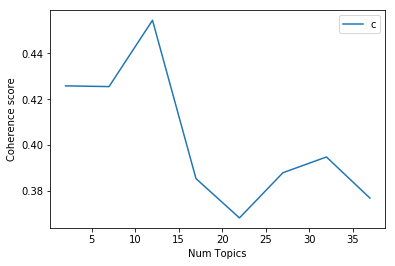

In [34]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_words_bigrams, start=2, limit=40, step=5)
limit=40; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [35]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4258
Num Topics = 7  has Coherence Value of 0.4255
Num Topics = 12  has Coherence Value of 0.4545
Num Topics = 17  has Coherence Value of 0.3852
Num Topics = 22  has Coherence Value of 0.368
Num Topics = 27  has Coherence Value of 0.3878
Num Topics = 32  has Coherence Value of 0.3947
Num Topics = 37  has Coherence Value of 0.3767


In [36]:
#Selecting optimal model
optimal_model = model_list[4]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(12,
  '0.000*"antonoff" + 0.000*"balance" + 0.000*"bracelets" + 0.000*"iphone" + '
  '0.000*"brooklyn" + 0.000*"fund" + 0.000*"loft" + 0.000*"lalalalala" + '
  '0.000*"parent" + 0.000*"runaway"'),
 (13,
  '0.117*"really" + 0.031*"santa" + 0.020*"ladadadada" + 0.003*"wouldnot" + '
  '0.003*"ohwoooh" + 0.000*"slam" + 0.000*"mel_geri" + 0.000*"afternoon" + '
  '0.000*"zigazig" + 0.000*"draw"'),
 (18,
  '0.032*"benz" + 0.026*"fan" + 0.016*"suicide" + 0.000*"greatest" + '
  '0.000*"older" + 0.000*"winnin" + 0.000*"steady" + 0.000*"heartache" + '
  '0.000*"captivate" + 0.000*"gallows"'),
 (19,
  '0.174*"alright" + 0.173*"ever" + 0.054*"nah_nah" + 0.029*"think" + '
  '0.029*"hate" + 0.025*"notice" + 0.018*"rubble" + 0.013*"dawg" + '
  '0.011*"stronger" + 0.010*"weak"'),
 (4,
  '0.128*"easy" + 0.034*"wherever" + 0.029*"wet" + 0.028*"child" + '
  '0.021*"sell_soul" + 0.021*"solo" + 0.020*"surface" + 0.017*"never" + '
  '0.016*"live" + 0.015*"glock_glock"'),
 (17,
  '0.254*"back" + 0.073*"hope

In [37]:
#Visualizing the cluster
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9     -0.304114 -0.168630       1        1  23.127602
0     -0.266034  0.010178       2        1  19.910528
2     -0.334595 -0.095549       3        1  15.737067
16    -0.145182  0.313305       4        1   6.914179
1     -0.160495  0.283230       5        1   6.572152
7     -0.109469 -0.108949       6        1   6.333113
15    -0.043611 -0.020633       7        1   2.983862
8      0.027336 -0.000112       8        1   2.781600
10     0.004479 -0.011814       9        1   2.557000
3     -0.008732 -0.044751      10        1   2.238722
14    -0.004930 -0.100339      11        1   2.088399
6     -0.072911 -0.019591      12        1   2.032513
21     0.051072  0.023294      13        1   1.488822
5      0.094538 -0.040607      14        1   1.075305
17     0.092631 -0.022318      15        1   1.049459
11     0.148975  0.002194      16        1   0.805650
20     0.153924  0.022028      17        1   0.795551
4      0.161177 -0.013612      18        1   0.740676
19     0.148070  0.002817      19        1   0.632910
13     0.185478 -0.004993      20        1   0.097748
18     0.191423 -0.002644      21        1   0.035251
12     0.190970 -0.002504      22        1   0.001894, topic_info=     Category        Freq        Term        Total  loglift  logprob
53    Default  3113.00000          go  3113.000000  30.0000  30.0000
72    Default  2199.00000        love  2199.000000  29.0000  29.0000
93    Default  1888.00000          oh  1888.000000  28.0000  28.0000
143   Default  2555.00000        yeah  2555.000000  27.0000  27.0000
125   Default  1030.00000        take  1030.000000  26.0000  26.0000
...       ...         ...         ...          ...      ...      ...
2788  Topic22     0.00025        sho'     0.869964   2.7204  -9.0269
2789  Topic22     0.00025    sounwave     0.869964   2.7204  -9.0269
2790  Topic22     0.00025         sow     0.869964   2.7204  -9.0269
2791  Topic22     0.00025  thundercat     0.869964   2.7204  -9.0269
2792  Topic22     0.00025      tilley     0.869964   2.7204  -9.0269

[1515 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
922      18  0.840422         '97
923      18  0.943599  'fore_sell
1066      5  0.391816       'gram
1066     19  0.391816       'gram
852       5  0.939468         .44
...     ...       ...         ...
1051     15  0.674587        york
1051     16  0.252970        york
1154      9  0.908250      youare
2256      9  0.721636           ‘
2256     10  0.257727           ‘

[1156 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 1, 3, 17, 2, 8, 16, 9, 11, 4, 15, 7, 22, 6, 18, 12, 21, 5, 20, 14, 19, 13])

In [39]:
#Building Word2Vec Model
model = Word2Vec(text, min_count=3,size= 100,workers=100, window =2, sg = 1)

In [45]:
#Creating the taxonamy based of the topics produced by the LDA model
topic_taxonamy = {
'adventure': {'nyc nashville london world japanese castle oak bear ridge days morning afternoon summer twenty number even count max \
jazz jam vibrations acoustic bamba sirens alright easy love mothafucking karma lucky tough tight worst girls guy boys mama pro stylist \
smith dj god ex slim phone news seed jean perfume ring gold rubble game pole'
},
'romantic':{'believe far end belong soul fear geronimo drown danger life blind trust proof shame deny motivation love feel hold baby \
lose young away mean care high hope well bed dance song colour tambourine jet stereo need home light everything sun fire whole dream touch \
carry ride reach bump scene stage sleep find crime say get know want come make take let see give think keep call look leave wait hear move \
stop break work meet start charm forget listen watch lay run taste true sister mister queen soldier ghost girl rise women toe shoulder hair \
dna back mind head heart body arm tear hundred late yesterday everyday days destiny seventeen anywhere time one always day ever night eye \
tonight last beautiful strong short single worth dry typical subliminal brave good real hard'
},
'sorrow':{'quite alone fool beauty kind affection imagination dear liar whole easier crush private excite barely silence better wrong \
dead alive deep crazy spirit hurt pride heartless stupid emotion choke bye mercy go find rather remember remain lie burn enough put paint \
help drink rest eat chase shoot ideas serve stand fill awake decide wear buy cry shake live pull save hang kill ride spend find hit open \
bury rhythm sell game line bus sound slide new star diamonds bow glass coffee heavy credit crack fire clear stone old ring white stock tree\
plan pipe hoodie glock buckle snake picture cost house front room heaven side club hell wherever anywhere inside outside world road natural\
drive follow storm miles highest wide globe around city hotel goodbye west motel bridge fall since sometimes dark eight three nights night\
later ray never face feet bone life die boy couple bleed special children palm fan older'
},

'classic':{'duchess duke princess prince oriane old king princesse duchesse blue society indeed shall country wife cousing people person \
friends charlus family mother men one two point eye general street anything title write letter flower bear receive open besides pass last days dinner base leave \
bloom conversation smile understand imagine interest'
},
'happy':{'free cold woo doubt flow loose dirty shine enjoy shadow pretty flex memories mess calm eternal ohoh electric hearts happy \
hand brain hair knees rum fee flame pack tune lady babe homie angel divine dance bring run already chance sing drink whoa blame breathe \
low shots jump act search race kiss grip withdraw swim clean steal feather fight spin dive garden river somewhere sea tree circle season'
 },
'slangy/modern':{'bitch fuck nigga niggas shit sure higher smoke party hot high bore wit yeah really fine friend people sir humble god pretty \
girl woman mine together voice another somebody anyone sweet without kiss music answer sleep marry say know piece learn admit tell ask walk \
wish speak sit play live hit beg catch miss look coupe honey door sugar wing plug blood sign wind long little money stick room middle nowhere'
}
}

In [41]:
#Model Results
model['happy']

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


array([ 0.0598839 ,  0.09697774, -0.14978415, -0.21175252, -0.07902735,
       -0.19487831, -0.06200431,  0.15122667,  0.2594547 ,  0.25970995,
       -0.01308068, -0.1965545 , -0.17140055, -0.32998717, -0.09157506,
        0.22876887,  0.03966099, -0.17462505, -0.08418222,  0.19616303,
       -0.27169737,  0.14713041, -0.10385238, -0.16013862,  0.02474883,
        0.23203947, -0.18472847,  0.29565704, -0.17502832,  0.0924205 ,
       -0.06796782, -0.27835053,  0.0371845 , -0.03755113, -0.11618943,
        0.41762707, -0.1237758 , -0.11464754,  0.44925642,  0.07430311,
        0.44933596,  0.01747189, -0.33924437, -0.09882458, -0.00328409,
       -0.2408462 ,  0.38681924, -0.25403747, -0.25297093, -0.1221566 ,
       -0.4052072 ,  0.08468568,  0.23387456, -0.34621847,  0.01686723,
       -0.02621943, -0.5826995 , -0.33716953,  0.48132834,  0.25576785,
        0.06700606,  0.32551694,  0.25636655, -0.03487202, -0.0311382 ,
       -0.02699146, -0.00321692,  0.17944711,  0.21324937, -0.13

In [42]:
#Does it make sense?
model.most_similar('sad')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('shin', 0.9921380877494812),
 ('surprise', 0.9920734167098999),
 ('momma', 0.9912195801734924),
 ('strength', 0.991125762462616),
 ('trouble', 0.9909136891365051),
 ('proud', 0.9908553957939148),
 ('shoulder', 0.9908309578895569),
 ('warmth', 0.9908260107040405),
 ('folks', 0.9904682636260986),
 ('hesitate', 0.9904072284698486)]

In [49]:
#Calculating cosine similarity
def vec_similarity(input1, input2, vectors):
    term_vectors = [np.zeros(300), np.zeros(300)]
    terms = [input1, input2]

    for index, term in enumerate(terms):
        for i, t in enumerate(term.split(' ')):
            try:
                term_vectors[index] += vectors[t]
            except:
                term_vectors[index] += 0

    result = (1 - spatial.distance.cosine(term_vectors[0], term_vectors[1]))
    if result is 'nan':
        result = 0

    return result


def vocab_check(vectors, words):
    output = list()
    for word in words:
        if word in vectors.wv.vocab:
            output.append(word.strip())

    return output


def calc_similarity(input1, input2, vectors):
    s1words = set(vocab_check(vectors, input1.split()))
    s2words = set(vocab_check(vectors, input2.split()))

    output = vectors.n_similarity(s1words, s2words)
    return output


def classify_topics(input, vectors):
    feed_score = dict()
    for key, value in topic_taxonomy.items():
        max_value_score = dict()
        # for label, keywords in value.items():
        max_value_score[key] = 0
        topic = (key + ' ' + list(value)[0]).strip()
        max_value_score[key] += float(calc_similarity(input, topic, vectors))

        sorted_max_score = sorted(max_value_score.items(), key=operator.itemgetter(1), reverse=True)[0]
        feed_score[sorted_max_score[0]] = sorted_max_score[1]
    return sorted(feed_score.items(), key=operator.itemgetter(1), reverse=True)[:3]

In [71]:
#extracting the winning topic and appending it to a list
chor = [' '.join(tx) for tx in chorus]
classification = []
for i in range(len(chor)):
    try:
        output1 = classify_topics(chor[i], model)
        classification.append(output1[0][0])
    except ZeroDivisionError:
        classification.append('NoNe')
    

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Call to deprecated `n_similarity` (Method will be removed in 4.0.0, use self.wv.n_similarity() instead).
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Call to deprecated `n_similarity` (Method will be removed in 4.0.0, use self.wv.n_similarity() instead).
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Call to deprecated `n_similarity` (Method will be removed in 4.0.0, use self.wv.n_similarity() instead).
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Call to deprecated `n_similarity` (Method will be removed in 4.0.0, use self.wv.n_similarity() instead).
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipyker

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Call to deprecated `n_similarity` (Method will be removed in 4.0.0, use self.wv.n_similarity() instead).
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Call to deprecated `n_similarity` (Method will be removed in 4.0.0, use self.wv.n_similarity() instead).
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Call to deprecated `n_similarity` (Method will be removed in 4.0.0, use self.wv.n_similarity() instead).
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Call to deprecated `n_similarity` (Method will be removed in 4.0.0, use self.wv.n_similarity() instead).
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipyker

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Call to deprecated `n_similarity` (Method will be removed in 4.0.0, use self.wv.n_similarity() instead).
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Call to deprecated `n_similarity` (Method will be removed in 4.0.0, use self.wv.n_similarity() instead).
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Call to deprecated `n_similarity` (Method will be removed in 4.0.0, use self.wv.n_similarity() instead).
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Call to deprecated `n_similarity` (Method will be removed in 4.0.0, use self.wv.n_similarity() instead).
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipyker

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Call to deprecated `n_similarity` (Method will be removed in 4.0.0, use self.wv.n_similarity() instead).
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Call to deprecated `n_similarity` (Method will be removed in 4.0.0, use self.wv.n_similarity() instead).
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Call to deprecated `n_similarity` (Method will be removed in 4.0.0, use self.wv.n_similarity() instead).
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Call to deprecated `n_similarity` (Method will be removed in 4.0.0, use self.wv.n_similarity() instead).
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipyker

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Call to deprecated `n_similarity` (Method will be removed in 4.0.0, use self.wv.n_similarity() instead).
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Call to deprecated `n_similarity` (Method will be removed in 4.0.0, use self.wv.n_similarity() instead).
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Call to deprecated `n_similarity` (Method will be removed in 4.0.0, use self.wv.n_similarity() instead).
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Call to deprecated `n_similarity` (Method will be removed in 4.0.0, use self.wv.n_similarity() instead).
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipyker

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Call to deprecated `n_similarity` (Method will be removed in 4.0.0, use self.wv.n_similarity() instead).
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Call to deprecated `n_similarity` (Method will be removed in 4.0.0, use self.wv.n_similarity() instead).
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Call to deprecated `n_similarity` (Method will be removed in 4.0.0, use self.wv.n_similarity() instead).
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Call to deprecated `n_similarity` (Method will be removed in 4.0.0, use self.wv.n_similarity() instead).
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipyker

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Call to deprecated `n_similarity` (Method will be removed in 4.0.0, use self.wv.n_similarity() instead).
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Call to deprecated `n_similarity` (Method will be removed in 4.0.0, use self.wv.n_similarity() instead).
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Call to deprecated `n_similarity` (Method will be removed in 4.0.0, use self.wv.n_similarity() instead).
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Call to deprecated `n_similarity` (Method will be removed in 4.0.0, use self.wv.n_similarity() instead).
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipyker

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Call to deprecated `n_similarity` (Method will be removed in 4.0.0, use self.wv.n_similarity() instead).
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Call to deprecated `n_similarity` (Method will be removed in 4.0.0, use self.wv.n_similarity() instead).
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Call to deprecated `n_similarity` (Method will be removed in 4.0.0, use self.wv.n_similarity() instead).
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Call to deprecated `n_similarity` (Method will be removed in 4.0.0, use self.wv.n_similarity() instead).
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipyker

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Call to deprecated `n_similarity` (Method will be removed in 4.0.0, use self.wv.n_similarity() instead).
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Call to deprecated `n_similarity` (Method will be removed in 4.0.0, use self.wv.n_similarity() instead).
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Call to deprecated `n_similarity` (Method will be removed in 4.0.0, use self.wv.n_similarity() instead).
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Call to deprecated `n_similarity` (Method will be removed in 4.0.0, use self.wv.n_similarity() instead).
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipyker

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Call to deprecated `n_similarity` (Method will be removed in 4.0.0, use self.wv.n_similarity() instead).
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Call to deprecated `n_similarity` (Method will be removed in 4.0.0, use self.wv.n_similarity() instead).
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Call to deprecated `n_similarity` (Method will be removed in 4.0.0, use self.wv.n_similarity() instead).
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Call to deprecated `n_similarity` (Method will be removed in 4.0.0, use self.wv.n_similarity() instead).
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipyker

In [72]:
print(classification[:10])
print(len(classification))

['slangy/modern', 'slangy/modern', 'slangy/modern', 'slangy/modern', 'slangy/modern', 'slangy/modern', 'romantic', 'slangy/modern', 'romantic', 'slangy/modern']
670


In [75]:
#Results
pd.Series(classification).value_counts()

romantic         448
slangy/modern    120
sorrow            43
adventure         23
classic           20
happy             15
NoNe               1
dtype: int64

In [81]:
#Final DF
df7 = pd.DataFrame(df6)
df7.insert(loc=6,column = 'classification',value = classification)
df7['chorus'] = chor
df7['lyrics'] = [' '.join(tx) for tx in text]
df7

artists            name  duration_ms  popularity       playlist  \
0            DaBaby             BOP       159714          90      RapCaviar   
1          Lil Baby            Woah       183011          86      RapCaviar   
2            DaBaby           VIBEZ       144935          88      RapCaviar   
3        NLE Choppa         Camelot       148759          90      RapCaviar   
4    Internet Money        Somebody       174333          85      RapCaviar   
..              ...             ...          ...         ...            ...   
665         Beyoncé         ALREADY       222529          70  Power Workout   
666         50 Cent  Just A Lil Bit       237706          75  Power Workout   
667             NSG          OT Bop       185760          70  Power Workout   
668         Stormzy      Wiley Flow       207365          76  Power Workout   
669          Skepta     Greaze Mode       168400          68  Power Workout   

       genre classification  \
0       None  slangy/modern   
1        NaN  slangy/modern   
2       None  slangy/modern   
3        NaN  slangy/modern   
4        NaN  slangy/modern   
..       ...            ...   
665      NaN  slangy/modern   
666  Hip-Hop       romantic   
667      NaN         sorrow   
668      NaN  slangy/modern   
669    Grime  slangy/modern   

                                                chorus  \
0    need shit bop let go fly past whip mouth watch...   
1    brand car noisy come roar skrrt ai get worry c...   
2    want fuck get time mmh mmh hop private plane g...   
3    ai go say much nigga speak hot shit fuck polic...   
4    want somebody 'body treat like somebody 'body ...   
..                                                 ...   
665  long live king king know king already already ...   
666  nigga really need bite lot girl bite crib bite...   
667  kruddz early year try hustler year quay quay q...   
668  wait make wing like design blow major things m...   
669  nafe small knees yeah see see freeze freeze ro...   

                                                lyrics  
0    know everybody wait mean like ever since drop ...  
1    car noisy come roarin' yeah yeah know come kno...  
2    let go yeah yeah neeko make motherfuckin beat ...  
3    yeah freshduzit yeah huh huh huh ai go say muc...  
4    bitch love prechorus jackin static jackin stat...  
..                                                 ...  
665  long live king king know king already already ...  
666  yeah shady aftermath gunit damn need bite bite...  
667  ogd drip talent save bore might go harrods man...  
668  wiley bruv look way approach birthday youngers...  
669  iama break law yeah iama break bank yeah iama ...  

[670 rows x 9 columns]

In [82]:
df7.to_csv('final_df.csv')

In [85]:
#Load DF with labels
df8 = pd.read_csv('final_df_2.csv',index_col =0)

In [86]:
df8.head(20)

artists                    name  duration_ms  popularity  \
0                   DaBaby                     BOP       159714          90   
1                 Lil Baby                    Woah       183011          86   
2                   DaBaby                   VIBEZ       144935          88   
3               NLE Choppa                 Camelot       148759          90   
4           Internet Money                Somebody       174333          85   
5                21 Savage                Immortal       254723          85   
6             Travis Scott     HIGHEST IN THE ROOM       175720          98   
7                   DaBaby  RAW SHIT (feat. Migos)       216677          81   
8                 Doja Cat                   Juicy       202333          84   
9   A Boogie Wit da Hoodie             Mood Swings       156893          81   
10               Lil Nas X   Panini - DaBaby Remix       151040          85   
11                The Game                The Code       349264          63   
12             Tones and I            Dance Monkey       209754          81   
13          Arizona Zervas                 ROXANNE       163636          95   
14              The Weeknd               Heartless       200080          89   
15                Maroon 5                Memories       189486         100   
16           Billie Eilish     everything i wanted       245425          97   
17             Post Malone                 Circles       215280          99   
18              The Weeknd         Blinding Lights       201573          83   
19                Dua Lipa         Don't Start Now       183290          96   

         playlist      genre classification          label  \
0       RapCaviar        NaN  slangy/modern  slangy/modern   
1       RapCaviar        NaN  slangy/modern  slangy/modern   
2       RapCaviar        NaN  slangy/modern  slangy/modern   
3       RapCaviar        NaN  slangy/modern  slangy/modern   
4       RapCaviar        NaN  slangy/modern       romantic   
5       RapCaviar        NaN  slangy/modern  slangy/modern   
6       RapCaviar        NaN       romantic  slangy/modern   
7       RapCaviar        NaN  slangy/modern  slangy/modern   
8       RapCaviar        NaN       romantic  slangy/modern   
9       RapCaviar        NaN  slangy/modern  slangy/modern   
10      RapCaviar        NaN       romantic  slangy/modern   
11      RapCaviar        NaN        classic         sorrow   
12  Global Top 50      Dance       romantic          happy   
13  Global Top 50        NaN       romantic          happy   
14  Global Top 50        NaN       romantic         sorrow   
15  Global Top 50        Pop       romantic         sorrow   
16  Global Top 50  indie pop       romantic       romantic   
17  Global Top 50        NaN       romantic       romantic   
18  Global Top 50        NaN       romantic         sorrow   
19  Global Top 50  Indie Pop       romantic         sorrow   

                                               chorus  \
0   need shit bop let go fly past whip mouth watch...   
1   brand car noisy come roar skrrt ai get worry c...   
2   want fuck get time mmh mmh hop private plane g...   
3   ai go say much nigga speak hot shit fuck polic...   
4   want somebody 'body treat like somebody 'body ...   
5   know slaughter immortal ai nothing change slau...   
6   get room fume yeah fill mind ideas highest roo...   
7   say want raw shit raw turn iama sit car bitch ...   
8   keep juicy juicy eat lunch yeah keep booty boo...   
9   beast gobling nigga let shit fly nigga want pr...   
10                        say want say want let go uh   
11  live code die code never ho bury sell soul liv...   
12  say dance dance dance ohohoh never see anybody...   
13  roxanne roxanne want party god damn roxanne ne...   
14  heartless back ways heartless paing get heartl...   
15  ones get cheer wish youare drink bring back me...   
16  say long hurt want lie learn could change way ...   
17  season change love go cold

In [91]:
#Calculate Accuracy
binary = [1 if df8.loc[i,'classification'] == df8.loc[i,'label'] else 0 for i in range(len(df8['classification']))]

print("accuracy:" + str(sum(binary)/len(df8.lyrics)))

accuracy:0.9343283582089552
